In [4]:
# Import to be able to import python package from src
import sys
sys.path.insert(0, '../src')

# **onTime Demo**

---
## Scenario

1. Creation of the model
2. Packaging of the model
3. Add the model to the library
4. Use the model with other tools from the library

## Structure

    .
    └── ontime
        ├── abstract     <- Used today
        ├── config
        ├── detectors    <- Used today
        ├── generators   <- Used today
        ├── metrics
        ├── models       <- Used today
        ├── plots       
        ├── processors
        ├── time_series  <- Used today
        └── utils


---
## Creation of the model

Import libraries

In [5]:
import pandas as pd
import ontime as on

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
/Users/fred.montet/Library/Caches/pypoetry/virtualenvs/ontime-FpQu8-YN-py3.10/lib/python3.10/site-packages/statsforecast/core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Generate some fake data

In [67]:
ts = on.generators.random().generate(start=pd.Timestamp('01-01-2023'), end=pd.Timestamp('12-31-2023'))
ts[0:5]

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)>
array([[[-0.58126402]],

       [[-1.36677965]],

       [[-1.98731443]],

       [[-3.63736368]],

       [[-4.18556985]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-01-05
  * component  (component) object 'random_walk'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

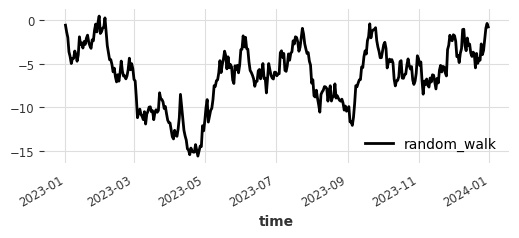

In [68]:
fig, ax = plt.subplots(figsize=(6, 2))
ts.plot(ax=ax);

Split in train and test

In [69]:
train, test = ts.split_after(pd.Timestamp('09-30-2023'))

Make a plot

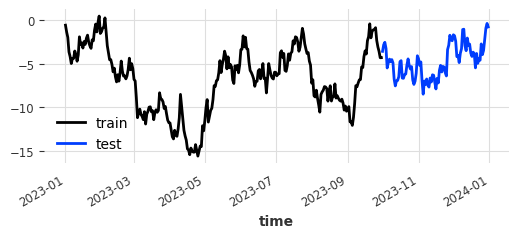

In [70]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(6, 2))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
ax.legend();

Create the model

In [71]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg 
from sklearn.neural_network import MLPRegressor

model = ForecasterAutoreg(
                regressor = MLPRegressor(),
                lags      = 30
             )
model.fit(y=train.pd_series())

/Users/fred.montet/Library/Caches/pypoetry/virtualenvs/ontime-FpQu8-YN-py3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [72]:
preds = model.predict(steps=7)

Plot the prediction

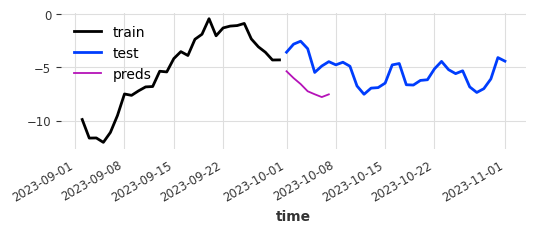

In [73]:
fig, ax = plt.subplots(figsize=(6, 2))
train.split_after(pd.Timestamp('09-01-2023'))[1].plot(ax=ax, label='train')
test.split_after(pd.Timestamp('11-01-2023'))[0].plot(ax=ax, label='test')
preds.plot(ax=ax, label='preds')
ax.legend();

---
## Packaging of the model

In [74]:
from ontime.abstract import AbstractBaseModel
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.neural_network import MLPRegressor


class MyPrivateModel(AbstractBaseModel):
    """
    Model to predict 14 days of activity given a training on 7 days.
    """

    def __init__(self):
        super().__init__()

    def fit(self, series):
        super().fit(series)
        self.model = ForecasterAutoreg(
                regressor = MLPRegressor(),
                lags      = 30
             )
        self.model.fit(y=series.pd_series())

    def predict(self):
        horizon = 7
        super().predict(horizon)
        predictions = self.model.predict(steps=horizon)
        return on.TimeSeries.from_series(predictions)



Try the model for fun

In [75]:
model = MyPrivateModel()

In [76]:
model.fit(train)

/Users/fred.montet/Library/Caches/pypoetry/virtualenvs/ontime-FpQu8-YN-py3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [77]:
ts = model.predict()

In [78]:
ts

<TimeSeries (DataArray) (time: 7, component: 1, sample: 1)>
array([[[-4.66085083]],

       [[-5.60022812]],

       [[-5.73205975]],

       [[-6.82137933]],

       [[-6.86367045]],

       [[-7.41164981]],

       [[-8.00938585]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-10-01 2023-10-02 ... 2023-10-07
  * component  (component) object 'pred'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

😎 It works 

---
## Add the model to the library

In [79]:
on.models.load('my_private_model', MyPrivateModel)

In [80]:
on.models.get_all()

['arima', 'catboost', 'TCN', 'my_private_model']

In [81]:
model = on.models.my_private_model()

Try again

In [82]:
model.fit(train)

/Users/fred.montet/Library/Caches/pypoetry/virtualenvs/ontime-FpQu8-YN-py3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [83]:
model.predict()

<TimeSeries (DataArray) (time: 7, component: 1, sample: 1)>
array([[[-5.06637136]],

       [[-5.23635497]],

       [[-5.63628331]],

       [[-5.81467531]],

       [[-6.01952293]],

       [[-5.90121908]],

       [[-6.13135852]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-10-01 2023-10-02 ... 2023-10-07
  * component  (component) object 'pred'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

---
## Use the model with other tools from the library

Use another tool from onTime

In [117]:
det = on.detectors.quantile(low_quantile=0.4, high_quantile=0.6)
det.fit(train);

In [118]:
preds = model.predict()

Plot

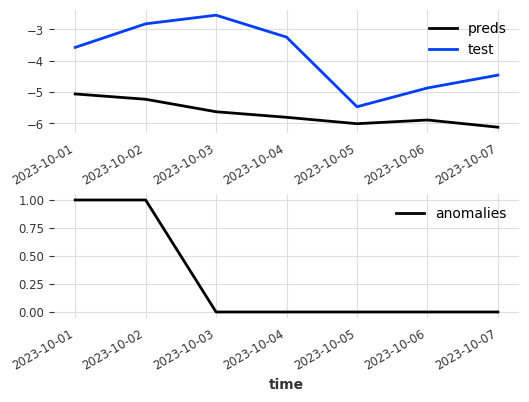

In [119]:
fig, ax = plt.subplots(2, figsize=(6, 4))
preds.plot(ax=ax[0], label='preds')
test[0:7].plot(ax=ax[0], label='test')
det.detect(preds).plot(ax=ax[1], label='anomalies')
fig.subplots_adjust(hspace=.5);

---
## Advantages of this approach

- possibility to share knowledge without complexity
- respect of the company privacy
- extendability of the library
- reusability

For DiagnoBat, some of your model(s) could be added to the main library, depending on your decision.

## Next steps

- First predictor/detectors given our specs
- Integration of a range of plots about root cause detection
- Benchmarking of different models
